# Dimension reduction comparison
In this notebook I'll compare three common unsupervised algorithms for dimensionality reduction

In [1]:
# Importing main libraries
import matplotlib
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from benchtools.src.clustering import build_features
from benchtools.src.datatools import separate_data
from sklearn.preprocessing import StandardScaler

# Importing the classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

# Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

# Dimensionality reduction
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Getting the data

I'll pre-process the data using the <code>benchtools</code> package. The next cell just need to be ran one time

In [2]:
build_features(path_data='..\..\events_anomalydetection.h5', nbatch=10, outname='RD_dataset')

A file with that name already exists


In [3]:
# Importing the data 
df = pd.read_csv("..\data\RD_dataset.csv")
df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,33,2580.489568,3.159663,109.0,0.0
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,97,3859.315047,3.581406,208.0,0.0
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,59,2480.769725,3.149348,196.0,0.0
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,89,2609.893413,3.298155,183.0,0.0
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,57,3313.488835,3.629229,169.0,1.0


Since it's just to test on scalers I'll do it on a smaller sample

In [4]:
# Eliminate the columns of mass so that the training is model-free 
df_RD = df.sample(100000, random_state = 1).drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
df_RD.head()

,pT_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,deltaR_j12,n_hadrons,label
264511,1636.540865,0.224496,-2.373993,1729.163350,0.371356,118,1547.619954,1.162014,0.710714,2722.719214,0.377317,59,3.224028,228.0,0.0
446040,1700.570450,-1.046567,-0.074009,2722.693611,0.173263,20,1471.042986,-0.496909,-3.102066,1660.217227,0.931903,39,3.077540,89.0,1.0
367350,1209.240264,1.501579,3.008941,2849.555797,0.693441,20,1192.250774,1.114281,-0.051151,2015.636945,0.527644,33,3.084503,86.0,0.0
510497,1331.228201,0.991312,2.934796,2041.150095,0.746076,13,1206.745736,0.501046,-0.197147,1366.214578,0.967665,54,3.170083,122.0,0.0
301480,1229.918669,-0.947064,2.870159,1828.159257,0.918211,39,1226.020830,0.063516,-0.261698,1238.924198,0.873326,42,3.290866,109.0,0.0


In [5]:
X, y = separate_data(df_RD, standarize=False)

I'll define a function that is a pipeline to train and get the metrics

In [6]:
def supervised_pipeline(X, y, classifiers, dimension_reduction=None):
    # To save the scores
    log_dict = {}
    
    for clf in tqdm(classifiers):
        name = clf.__class__.__name__

        # Simple pipeline
        if dimension_reduction is None:
            steps = [('ss', StandardScaler()), ('clf', clf)]
        else:
            steps = [('ss', StandardScaler()), ('dr', dimension_reduction), ('clf', clf)]
        
        model = Pipeline(steps=steps)

        # Evaluate model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        n_scores = cross_validate(model, X, y, scoring=['balanced_accuracy', 'f1', 'average_precision', 'roc_auc'], cv=cv, n_jobs=-1)

        # Adding metrics to a dict
        log_dict[name]=n_scores

    log = pd.DataFrame.from_dict(log_dict)
    mean_scores = log.applymap(np.mean)
    std_scores = log.applymap(np.std)

    return mean_scores.T, std_scores.T

Lastly, this is the list of supervised algorithms that will be trained. I already selected fewer based on the results obtained in notebook 13.

In [7]:
# Listing the classifiers to compare
classifiers = [RandomForestClassifier(),
                GradientBoostingClassifier(),
                QuadraticDiscriminantAnalysis(), 
                MLPClassifier()]

## Training
### Without reducing dimensions

In [8]:
mean_none, std_none = supervised_pipeline(X, y, classifiers, dimension_reduction=None)

  0%|          | 0/4 [00:00<?, ?it/s]

###  PCA

In [9]:
def variance_components(dimension_reduction, X, y=None):
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Visualize
    try:
        dimension_reduction.fit_transform(X_scaled)
    except:
        dimension_reduction.fit_transform(X_scaled, y)
    
    # Ratio of the variance for number of components
    dr_variance = dimension_reduction.explained_variance_ratio_
    
    # Getting the number of components for 95% variance
    total_var = 0
    n_components = 0
    for component_var in dr_variance:
        if total_var >= 0.95: 
            # Get the number of components
            n_components-=1
            break
        # sum the variance of the components
        total_var+=component_var
        n_components+=1
        
    # Plot
    n_bar = dr_variance.shape
    plt.figure(figsize=(8, 6))
    plt.bar(range(n_bar[0]), dr_variance, alpha=0.5, align='center', 
            label='No. components for 95% variance: {}'.format(n_components))
    plt.legend()
    plt.ylabel('Variance ratio')
    plt.xlabel('Principal components')
    plt.title('Variance ratio for component')
    plt.show()

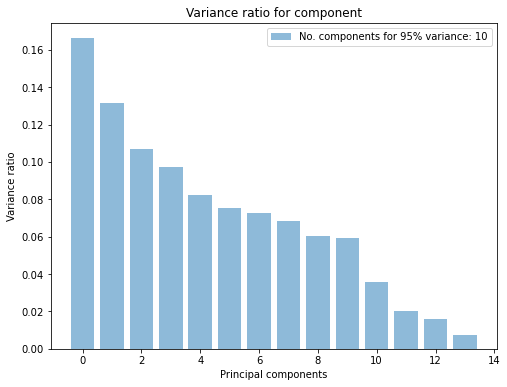

In [10]:
variance_components(PCA(), X)

In [11]:
mean_pca, std_pca = supervised_pipeline(X, y, classifiers, dimension_reduction=PCA(n_components=10))

  0%|          | 0/4 [00:00<?, ?it/s]

### SVD

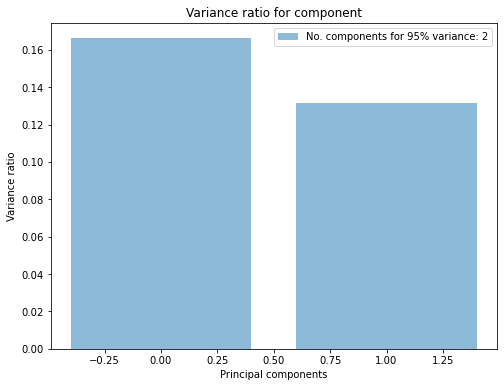

In [12]:
variance_components(TruncatedSVD(), X)

In [13]:
mean_svd, std_svd = supervised_pipeline(X, y, classifiers, dimension_reduction=TruncatedSVD(n_components=10))

  0%|          | 0/4 [00:00<?, ?it/s]

### LDA

In [14]:
mean_lda, std_lda = supervised_pipeline(X, y, classifiers, dimension_reduction=LinearDiscriminantAnalysis(n_components=1))

  0%|          | 0/4 [00:00<?, ?it/s]

## Comparison
I want to plot each variable comparing the result for each classifier.

In [15]:
# Concat with multiindex
df = pd.concat([mean_none, mean_pca, mean_svd, mean_lda], axis=1, keys=['None','PCA', 'SVD', 'LDA'])
df

None                                    \
                                fit_time score_time test_balanced_accuracy   
RandomForestClassifier         39.692023   0.603919               0.788205   
GradientBoostingClassifier     52.215841   0.072538               0.788444   
QuadraticDiscriminantAnalysis   0.448601   0.067087               0.811882   
MLPClassifier                  85.788658   0.066689               0.838284   

                                                                             \
                                test_f1 test_average_precision test_roc_auc   
RandomForestClassifier         0.695829               0.793335     0.954196   
GradientBoostingClassifier     0.682534               0.774455     0.954248   
QuadraticDiscriminantAnalysis  0.672800               0.725717     0.935691   
MLPClassifier                  0.747683               0.823414     0.966818   

                                     PCA                                    \
                                fit_time score_time test_balanced_accuracy   
RandomForestClassifier         42.130121   0.520907               0.794238   
GradientBoostingClassifier     48.901095   0.090326               0.793575   
QuadraticDiscriminantAnalysis   1.331209   0.067021               0.797155   
MLPClassifier                  56.136226   0.067885               0.829817   

                                         ...                    SVD            \
                                test_f1  ... test_balanced_accuracy   test_f1   
RandomForestClassifier         0.695757  ...               0.794128  0.695749   
GradientBoostingClassifier     0.680928  ...               0.793575  0.680928   
QuadraticDiscriminantAnalysis  0.660991  ...               0.797155  0.660991   
MLPClassifier                  0.729933  ...               0.827836  0.729280   

                                                                         LDA  \
                              test_average_precision test_roc_auc   fit_time   
RandomForestClassifier                      0.781569     0.952518  21.634389   
GradientBoostingClassifier                  0.756764     0.951014   8.324123   
QuadraticDiscriminantAnalysis               0.713925     0.937976   0.626991   
MLPClassifier                               0.809176     0.963654  11.049874   

                                                                           \
                              score_time test_balanced_accuracy   test_f1   
RandomForestClassifier          0.606246               0.687344  0.432294   
GradientBoostingClassifier      0.069082               0.723000  0.549887   
QuadraticDiscriminantAnalysis   0.048337               0.728455  0.555393   
MLPClassifier                   0.059707               0.721457  0.549357   

                                                                   
                              test_average_precision test_roc_auc  
RandomForestClassifier                      0.423005     0.831677  
GradientBoostingClassifier                  0.571685     0.920579  
QuadraticDiscriminantAnalysis               0.556093     0.920576  
MLPClassifier                               0.589935     0.921274  

[4 rows x 24 columns]

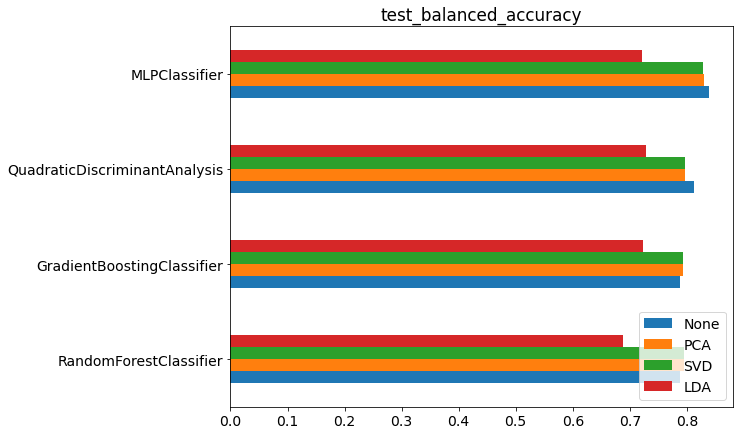

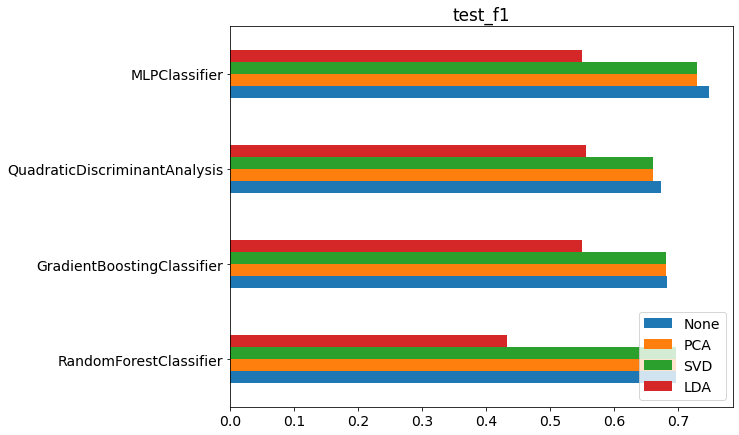

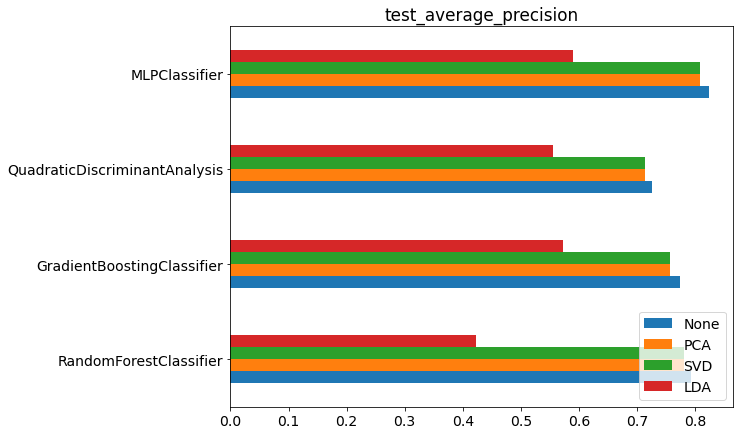

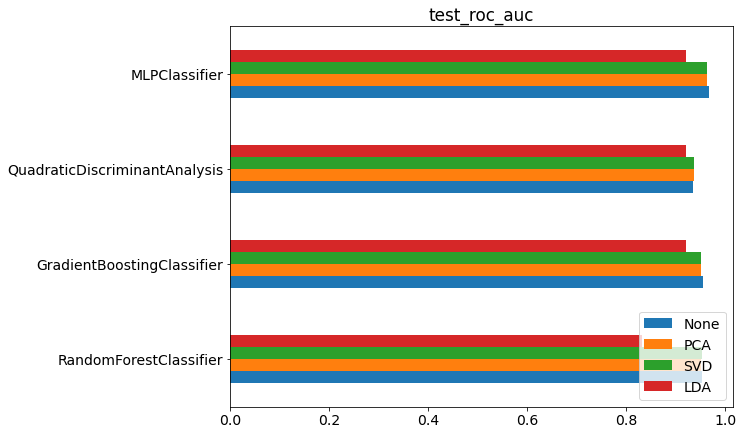

In [16]:
columns = mean_none.drop(['fit_time','score_time'],axis=1).columns.tolist()

for variable in columns:
    matplotlib.rcParams.update({'font.size': 14})
    df.iloc[:, df.columns.get_level_values(1)==variable].plot.barh(figsize=(9,7), title=variable)
    plt.legend(['None','PCA', 'SVD', 'LDA'], loc="lower right")
    plt.show()

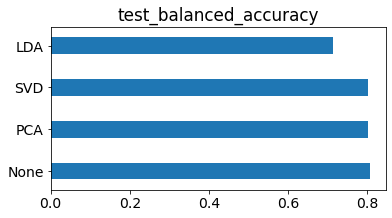

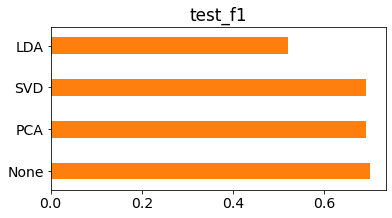

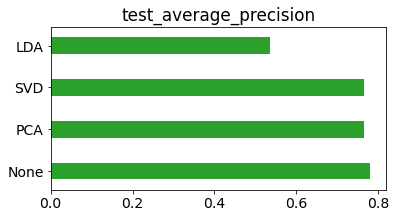

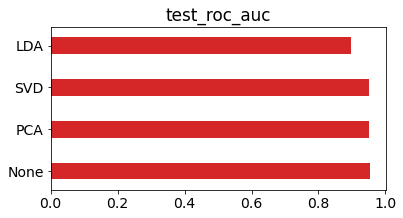

In [17]:
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink', 'tab:olive', 'tab:cyan']
for variable, color in zip(columns, color_list):  
    df.mean().loc[:,variable].plot.barh(figsize=(6,3), color=color, title=variable, stacked=True, width=0.4)
    plt.show()

In general, reducing dimensions with these methods it's not useful.